# visualize cluster trajectory

In [14]:
import os
import pickle
import time

import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.manifold import TSNE
import joblib

In [5]:
model_path = '/sciclone/geograd/stmorse/reddit/mbkm_50/models'

In [8]:
start_year = 2008
end_year = 2008
start_month = 1
end_month = 12

years = [str(y) for y in range(start_year, end_year+1)]
months = [f'{m:02}' for m in range(start_month, end_month+1)]
yrmo = [(yr, mo) for yr in years for mo in months]

In [9]:
C = []
Ck = -1  # TODO: doesn't need to be the same every month
for year, month in yrmo:
    with open(os.path.join(model_path, f'model_cc_{year}-{month}.npz'), 'rb') as f:
        cc = np.load(f)['cc']
        Ck = cc.shape[0]
        C.append(cc)
C = np.vstack(C)
C.shape

(600, 384)

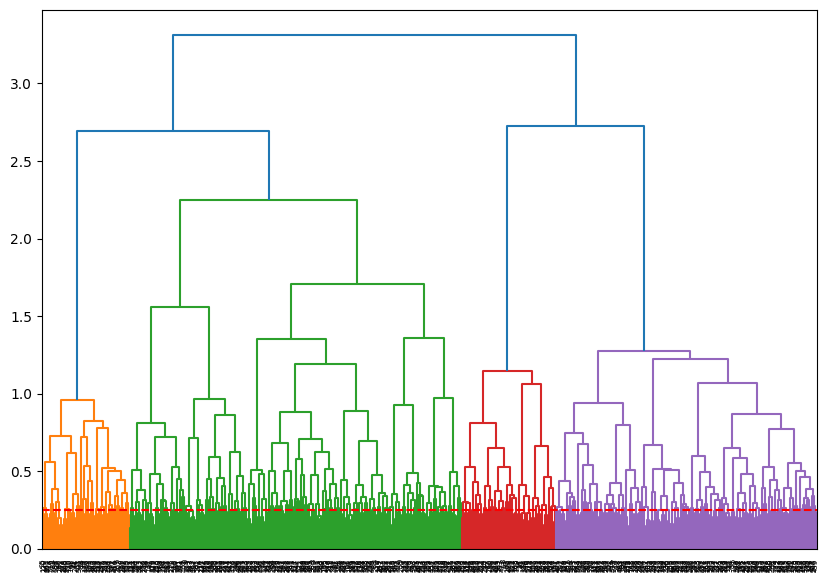

In [10]:
Z = linkage(C, 'ward')
fig = plt.figure(figsize=(10, 7))
dendrogram(Z)
plt.axhline(y=0.25, color='r', linestyle='--')
# fig.savefig('dendrogram.png', dpi=fig.dpi)  
plt.show()

In [13]:
ahc = AgglomerativeClustering(
    n_clusters=None,
    distance_threshold=0.5,
    linkage='ward',
)
ahc.fit(C)
ahc.n_clusters_

68

In [15]:
# embed all centroids in 2-d
tsne = TSNE(
    n_components=2,
    perplexity=30,
    early_exaggeration=12,
)
CT = tsne.fit_transform(C)

In [16]:
# find a cluster with at least 10 entries
ccounts = np.unique(ahc.labels_, return_counts=True)
ccounts

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67]),
 array([19, 10, 20, 18, 11, 18,  7, 17, 16, 10,  6, 10, 10, 16, 16, 10, 14,
         6, 12,  7,  8, 15,  7,  8,  9,  9,  9, 13,  5, 11,  7,  9,  8,  3,
         8,  7, 12,  9,  3, 10,  7,  8, 11,  5, 10,  6,  4, 11,  4,  5,  6,
        10,  5,  4,  7,  6,  8,  4,  4,  5,  4,  4,  4, 18, 11,  1,  3,  2]))

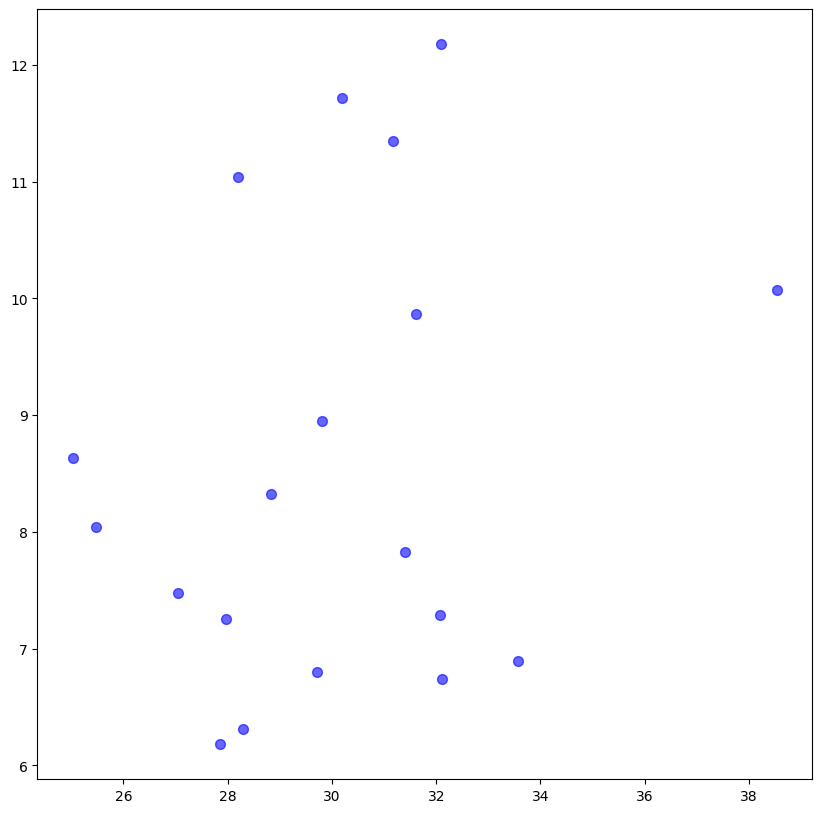

In [17]:
# cluster of interest
coi = 0

# get label indices
idx = np.where(ahc.labels_ == coi)[0]

fig, ax = plt.subplots(1,1, figsize=(10,10))

ax.scatter(CT[idx,0], CT[idx,1], s=50, c='b', alpha=0.6)

plt.show()

# cluster trajectory via AHC

In [54]:
import pickle

import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage

In [44]:
base_path = '/sciclone/geograd/stmorse/reddit/mbkm_50'
months = ['03', '04', '05']

# open cluster centers
ccs = {}
for i in range(3):
    with open(f'{base_path}/models/model_cc_2011-{months[i]}.npz', 'rb') as f:
        ccs[i] = np.load(f)['cc']
C = np.vstack([ccs[i] for i in range(len(ccs))])
print(C.shape)

# open tfidf
tfidfs = {}
T = []
for i in range(3):
    with open(f'{base_path}/tfidf/tfidf_2011-{months[i]}.pkl', 'rb') as f:
        tfidfs[i] = pickle.load(f)
    # TODO: hacky, maybe 'tfidf' shouldn't be a dict
    for j in range(len(tfidfs[i]['tfidf'].keys())):
        T.append(tfidfs[i]['tfidf'][j]['keywords'])
print(len(T))

(150, 384)
150


(150, 384)


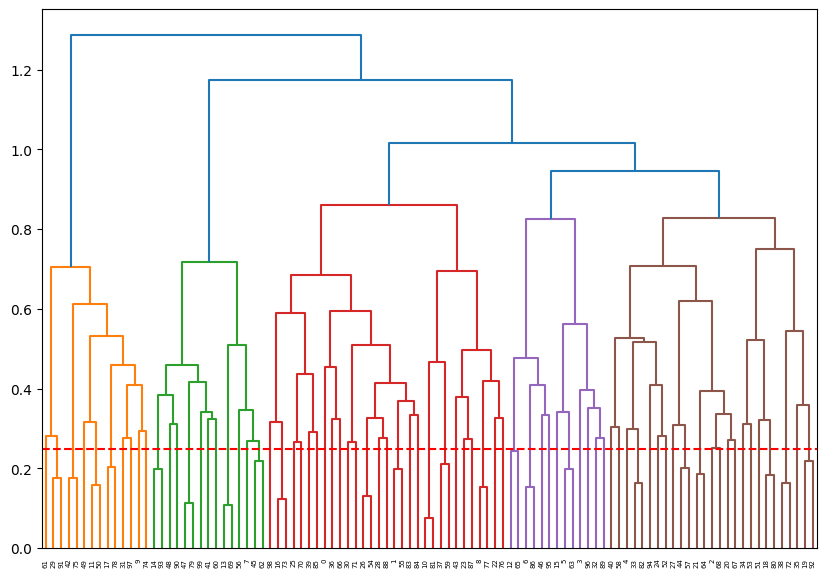

In [51]:
# cluster centroids
C = np.vstack([ccs[i] for i in range(len(ccs))])
print(C.shape)

# Perform hierarchical/agglomerative clustering
Z = linkage(C[:100], 'ward')

# Plot the dendrogram
plt.figure(figsize=(10, 7))
dendrogram(Z)
plt.axhline(y=0.25, color='r', linestyle='--')

plt.show()

In [52]:
ahc = AgglomerativeClustering(
    n_clusters=None, 
    distance_threshold=0.25, 
    linkage='ward'
)

ahc.fit(C)
ahc.n_clusters_

94

In [49]:
k = 2
idx = np.where(ahc.labels_ == k)[0]
print(idx)
for x in idx:
    print(f'{x}: {T[x][:5]}')

[ 29  91 125]
29: ['government' 'tax' 'wealth' 'taxes' 'pay']
91: ['money' 'government' 'profits' 'billion' 'companies']
125: ['spending' 'cash' 'rich' 'spend' 'debt']


# checking out sentences

In [56]:
import bz2
import json

In [64]:
base_path = '/sciclone/data10/twford/reddit/reddit/comments'
all_data = []
k = 0
m = 0
with bz2.BZ2File(f'{base_path}/RC_2011-03.bz2', 'rb') as f:
    for line in f:
        if k > 100:
            break
        entry = json.loads(line)
        m += 1
        if 'body' not in entry or entry['author']=='[deleted]':
            continue
        if entry['subreddit']=='politics':
            all_data.append(entry)
            k += 1
print(m)

3154


In [63]:
len(all_data)

101

In [65]:
all_data[0]

{'controversiality': 0,
 'link_id': 't3_fuhez',
 'subreddit_id': 't5_2cneq',
 'edited': False,
 'created_utc': '1298937603',
 'name': 't1_c1ir2ui',
 'downs': 0,
 'distinguished': None,
 'score_hidden': False,
 'subreddit': 'politics',
 'gilded': 0,
 'author_flair_text': None,
 'id': 'c1ir2ui',
 'body': "but its not teachers who caused the current fiscal crisis. Its government handouts to mega corporations and tax cuts for the wealthy. So why should teachers and the middle class have to be the ones who sacrifice?\n\nperhaps the private sector could learn something from unions? I imagine that living life constantly on the edge fearing your healthcare/retirement fund might be gambled away by management is a big negative. \n\nMan what century is America living in? Kicking it old school ala 1900 with labour rights. All around the world, people are looking at Wisconsin and thinking geez, next they'll be bringing back child labour. Which incidently the GOP attempted to do.",
 'archived': True

# Cluster trajectory testing

In [1]:
import pickle

import matplotlib.pyplot as plt
import numpy as np

In [2]:
# with open('/sciclone/geograd/stmorse/reddit/embeddings/embeddings_2009-03.npz', 'rb') as f:
#     embedding0 = np.load(f)

# with open('/sciclone/geograd/stmorse/reddit/embeddings/embeddings_2009-04.npz', 'rb') as f:
#     embedding1 = np.load(f)

with open('/sciclone/geograd/stmorse/reddit/test/tfidf_mbkm_80/tfidf_2011-03.pkl', 'rb') as f:
    tfidf0 = pickle.load(f)

with open('/sciclone/geograd/stmorse/reddit/test/tfidf_mbkm_80/tfidf_2011-04.pkl', 'rb') as f:
    tfidf1 = pickle.load(f)

with open('/sciclone/geograd/stmorse/reddit/test/maps_mbkm_80/maps_2011-03.pkl', 'rb') as f:
    output = pickle.load(f)

In [3]:
tfidf0.keys(), output.keys()

(dict_keys(['year', 'month', 'full', 'tfidf']),
 dict_keys(['year', 'month', 'cluster_map', 'similarity']))

In [4]:
tfidf0['tfidf'][0].keys()

dict_keys(['sample_indices', 'keywords'])

In [6]:
n0 = len(tfidf0['tfidf'])

for i in range(5, 10):
    print(i)
    print(tfidf0['tfidf'][i]['keywords'])
    idx = np.where(output['similarity'][i] > 0)[0]
    for j in idx:
        print(f'  {j}: {output['similarity'][i,j]:.3f} -- {tfidf1['tfidf'][j]['keywords']}')

5
['king' 'aliens' 'marry' 'gases' 'scheherazade' 'virgins' 'blah' 'aladdin'
 'prints' 'belief' 'sleep' 'tale' 'visited' 'nights' 'greenhouse'
 'penthouse' 'altruism' 'talks' 'genes' 'color']
  10: 0.026 -- ['philosophy' 'fiber' 'yang' 'fountainhead' 'thompson' 'null' 'kan' 'int'
 'rand' 'objective' 'comcast' 'religion' 'blah' 'nervous' 'peta'
 'evolutionary' 'worry' 'proud' 'interdisciplinary' 'motors']
  19: 0.026 -- ['gene' 'therapy' 'dun' 'genes' 'cells' 'paste' 'sangamo' 'hiv' 'miter'
 'vortexoptics' 'pst' 'immune' 'optics' 'democracy' 'finger' 'albeit'
 'patients' 'vivo' 'cps' 'cancers']
  54: 0.026 -- ['doot' 'vcs' 'isp' 'vr' 'cc' 'files' 'truth' 'tank' 'blah'
 'libertarianism' 'norway' 'distance' 'draw' 'squirrels' 'fucksouthdakota'
 'hayek' 'dee' 'hdi' 'frogs' 'nsa']
  59: 0.053 -- ['greenhouse' 'plumber' 'gases' 'warming' 'global' 'navy' 'danger' 'pic'
 'cent' 'guitar' 'per' 'families' 'yokosuka' 'nitrous' 'methane'
 'capability' 'globe' 'machine' 'oxide' 'affected']
  61: 0.

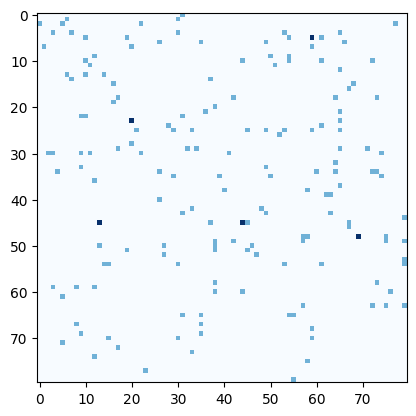

In [16]:
plt.imshow(output['similarity'], cmap='Blues', vmin=0, vmax=np.amax(output['similarity']))

# Bipartite graph test

In [3]:
import networkx as nx

In [6]:
G = nx.Graph()

n = 4

U = [f'u{i}' for i in range(n)]
V = [f'v{i}' for i in range(n)]
G.add_nodes_from(U, bipartite=0)
G.add_nodes_from(V, bipartite=1)

B = np.array([
    [0, 0.4, 0, 0.01],
    [0, 0.8, 0, 0.02],
    [0.9, 0, 0, 0],
    [0.1, 0, 0.1, 0.85]
])

threshold = 0.1

for i in range(B.shape[0]):
    for j in range(B.shape[1]):
        if B[i,j] >= threshold:
            G.add_edge(U[i], V[j])

connected_components = list(nx.connected_components(G))

for i, component in enumerate(connected_components):
    print(f'{i}: {component}')

0: {'v1', 'u1', 'u0'}
1: {'u3', 'v3', 'v0', 'v2', 'u2'}
